# **Import and Load data**

In [0]:
import pandas as pd
import numpy as np
from PIL import Image
import shutil
from torchvision import models
import torch.nn as nn
import torch
import json
import time
import pickle
import seaborn as sn
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from zipfile import ZipFile 
from matplotlib import pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [0]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **Data Processing and Augmentation (DO NOT RUN THIS SECTION)**


**Split the dataset into training set and testing set**

In [0]:
df = pd.read_csv("artists.csv")
paintings, labels = [], []
for i in range(50):
  name = df["name"][i]
  tmp = name.split(" ")
  artist = ""
  for j in range(len(tmp)):
    artist += tmp[j]+"_"
  num_paintings = int(df["paintings"][i])
  for k in range(1, num_paintings+1):
    fileName = artist + str(k) + ".jpg"
    paintings.append(fileName)
    labels.append(artist)
  
X_train, X_test, y_train, y_test = train_test_split(paintings, labels, train_size=0.8)

Store the name of paintings in training and testing datasets for easy future retrieval



In [0]:
with open("X_train.txt", "w+") as f:
    json.dump(X_train, f)
with open("X_test.txt", "w+") as f:
    json.dump(X_test, f)

Group paintings in training and testing datasets by artist

In [0]:
for painting in X_train:
  l = painting.split("_")
  directory = ""
  for i in range(len(l)-1):
    directory += l[i] + "_"
  directory = directory[:len(directory)-1]
  shutil.move("images/"+directory+"/"+painting, "train/"+directory+"/"+painting)

for painting in X_test:
  l = painting.split("_")
  directory = ""
  for i in range(len(l)-1):
    directory += l[i] + "_"
  directory = directory[:len(directory)-1]
  shutil.move("images/"+directory+"/"+painting, "val/"+directory+"/"+painting)

**Rotate every painting by 180 degrees and add the rotated copy into corresponding dataset for data augmentation**

In [0]:
for i in range(len(X_test)):
    painting = X_test[i]
    if i%50 == 0 :
        print(i)
    paintName = painting.split(".")[0]
    tmp = painting.split("_")
    directory = ""
    for i in range(len(tmp)-1):
        directory += tmp[i] + "_"
    directory = directory[:len(directory)-1]
    img = Image.open("./val/"+directory+"/"+painting)
    img_rotated = img.rotate(180)
    img_rotated.save("./val/"+directory+"/"+paintName+"_"+str(i)+".jpg", "JPEG")

for i in range(len(X_train)):
    painting = X_train[i]
    if i%100 == 0 :
        print(i)
    paintName = painting.split(".")[0]
    tmp = painting.split("_")
    directory = ""
    for i in range(len(tmp)-1):
        directory += tmp[i] + "_"
    directory = directory[:len(directory)-1]
    img = Image.open("./train/"+directory+"/"+painting)
    img_rotated = img.rotate(180)
    img_rotated.save("./train/"+directory+"/"+paintName+"_"+str(i)+".jpg", "JPEG")

# **Define Models**

Unzip the training and testing files

In [0]:
with ZipFile("/content/gdrive/My Drive/Painting Dataset/train.zip", 'r') as zip_f: 
  zip_f.extractall(path='/content') 
with ZipFile("/content/gdrive/My Drive/Painting Dataset/val.zip", 'r') as zip_f: 
  zip_f.extractall(path='/content')    

Prepare the data for training

In [0]:
train_directory = 'train'
val_directory = 'val'
preprocess = transforms.Compose([
              transforms.RandomResizedCrop(224), # random resized crop is used 
                                                 # for data augmentation
              transforms.ToTensor(), 
              transforms.Normalize((0.4914, 0.4822, 0.4465),
                                   (0.2023, 0.1994, 0.2010))
              ])
train_data = ImageFolder(train_directory, transform=preprocess)

val_data = ImageFolder(val_directory, transform=preprocess)

Define models

In [0]:
n_category = 50
# Resnet 18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(512, n_category)
# Resnet 50
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(2048, n_category)
# Resnet 101
resnet101 = models.resnet101(pretrained=True)
resnet101.fc = nn.Linear(2048, n_category)
# GoogleNet
googleNet = models.googlenet(pretrained=True)
googleNet.fc = nn.Linear(1024, n_category)
# VGG 11 with batch normalization
vgg11 = models.vgg11_bn(pretrained=True)
vgg11.classifier[6] = nn.Linear(4096, n_category)
# VGG 19 with batch normalization
vgg19 = models.vgg19_bn(pretrained=True)
vgg19.classifier[6] = nn.Linear(4096, n_category)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 46.9MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 64.8MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:03<00:00, 46.2MB/s]
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:01<00:00, 39.9MB/s]
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:08<00:00, 62.2MB/s]
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/t

# **Model Training**

Install tqdm

In [0]:
!pip install tqdm --upgrade

     |████████████████████████████████| 61kB 2.0MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


Write two helper functions, train and evaluat, which are later used in the train_model function

In [0]:
from tqdm.notebook import tqdm
import torch.optim as optim
from sklearn.metrics import f1_score, recall_score, precision_score

def train(classifier, criterion, optimizer, trainLoader):
    epoch_loss = 0
    epoch_correct = 0
    classifier.cuda()
    classifier.train()
    record_pred = torch.FloatTensor().cpu()
    record_gt = torch.LongTensor().cpu()
    for i, (x, y) in tqdm(enumerate(trainLoader)):
        x, y = x.cuda(), y.cuda()
        
        optimizer.zero_grad()
        predictions = classifier(x)
        loss = criterion(predictions, y)

        epoch_correct += torch.eq(torch.argmax(predictions, dim=1), y).sum().item()

        record_pred = torch.cat([record_pred, torch.argmax(predictions, dim=1).cpu().type(torch.FloatTensor)], dim=0)
        record_gt = torch.cat([record_gt, y.cpu()], dim=0)

        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    record_pred = record_pred.view(-1)
    record_gt = record_gt.view(-1)
    f1 = f1_score(record_gt, record_pred, average='weighted')
    precision = precision_score(record_gt, record_pred, average='weighted')
    recall = recall_score(record_gt, record_pred, average='weighted')
    print('Train f1', f1)
    print('Train precision', precision)
    print('Train recall', recall)
    return epoch_loss / len(trainLoader.dataset), epoch_correct / len(trainLoader.dataset)

def evaluate(classifier, criterion, optimizer, validLoader):
  epoch_loss = 0
  epoch_correct = 0
  classifier.cuda()
  classifier.eval()
  record_pred = torch.FloatTensor().cpu()
  record_gt = torch.LongTensor().cpu()
  with torch.no_grad():
      for i, (x, y) in tqdm(enumerate(validLoader)):
          x, y = x.cuda(), y.cuda()

          predictions = classifier(x)
          
          loss = criterion(predictions, y)
          record_pred = torch.cat([record_pred, torch.argmax(predictions, dim=1).cpu().type(torch.FloatTensor)], dim=0)
          record_gt = torch.cat([record_gt, y.cpu()], dim=0)

          epoch_loss += loss.item()
          epoch_correct += torch.eq(torch.argmax(predictions, dim=1), y).sum().item()
      record_pred = record_pred.view(-1)
      record_gt = record_gt.view(-1)
      f1 = f1_score(record_gt, record_pred, average='weighted')
      precision = precision_score(record_gt, record_pred, average='weighted')
      recall = recall_score(record_gt, record_pred, average='weighted')
      print('Val f1', f1)
      print('Val precision', precision)
      print('Val recall', recall)
  return epoch_loss / len(validLoader.dataset), epoch_correct / len(validLoader.dataset)

Define the train_model function which can be used to train different models

In [0]:
def train_model(classifier, criterion, optimizer, 
                trainSet, testSet, n_epochs = 30):
    params = {  
        'batch_size':64,
        'shuffle':True,
        'num_workers':0,
    }
    train_ls_acc, valid_ls_acc = [], []
    for epoch in range(n_epochs):
        train_loader = DataLoader(trainSet, **params)
        val_loader = DataLoader(testSet, **params)

        start_time = time.time()
        
        train_loss, train_acc = train(classifier, criterion, optimizer, train_loader)
        valid_loss, valid_acc = evaluate(classifier, criterion, optimizer, val_loader)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        epoch_mins = int(elapsed_time/60)
        epoch_secs = int(elapsed_time - epoch_mins*60)
        
        train_ls_acc.append((train_loss, train_acc))
        valid_ls_acc.append((valid_loss, valid_acc))
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    return train_ls_acc, valid_ls_acc

**Train all layers in ResNet50**

In [0]:
model = resnet50
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.SGD(model.parameters(), lr)
train_ls_acc, valid_ls_acc = train_model(model, criterion, optimizer, train_data, val_data, n_epochs=10)


Train f1 0.20605343526963577
Train precision 0.27413791104650453
Train recall 0.1830224985198342



Val f1 0.3271848857519046
Val precision 0.41625755585654617
Val recall 0.30650887573964497
Epoch: 01 | Epoch Time: 7m 30s
	Train Loss: 0.053 | Train Acc: 18.30%
	 Val. Loss: 0.046 |  Val. Acc: 30.65%



Train f1 0.4103226082247805
Train precision 0.4669599688999808
Train recall 0.3960923623445826



Val f1 0.43129251360349385
Val precision 0.5059176053220584
Val recall 0.4198224852071006
Epoch: 02 | Epoch Time: 6m 54s
	Train Loss: 0.043 | Train Acc: 39.61%
	 Val. Loss: 0.040 |  Val. Acc: 41.98%



Train f1 0.49160191415213433
Train precision 0.5353759034795881
Train recall 0.4855683836589698



Val f1 0.5013183018892479
Val precision 0.5616830062573726
Val recall 0.4908284023668639
Epoch: 03 | Epoch Time: 6m 53s
	Train Loss: 0.038 | Train Acc: 48.56%
	 Val. Loss: 0.037 |  Val. Acc: 49.08%



Train f1 0.5414712650446584
Train precision 0.5771804995675474
Train recall 0.5387063351095323



Val f1 0.5256664308022281
Val precision 0.5856700904019376
Val recall 0.5186390532544378
Epoch: 04 | Epoch Time: 6m 54s
	Train Loss: 0.036 | Train Acc: 53.87%
	 Val. Loss: 0.035 |  Val. Acc: 51.86%



Train f1 0.5753962653840166
Train precision 0.6080904295145457
Train recall 0.5735642391947898



Val f1 0.5715925587139631
Val precision 0.6197608225197367
Val recall 0.5627218934911242
Epoch: 05 | Epoch Time: 6m 53s
	Train Loss: 0.034 | Train Acc: 57.36%
	 Val. Loss: 0.032 |  Val. Acc: 56.27%



Train f1 0.6081721995338041
Train precision 0.6352263774685832
Train recall 0.6072380106571936



Val f1 0.5903578641888156
Val precision 0.6346150231020511
Val recall 0.5831360946745562
Epoch: 06 | Epoch Time: 6m 54s
	Train Loss: 0.032 | Train Acc: 60.72%
	 Val. Loss: 0.031 |  Val. Acc: 58.31%



Train f1 0.6231306458138818
Train precision 0.6459911158272933
Train recall 0.6230757844878626



Val f1 0.60803129814391
Val precision 0.6477767416341529
Val recall 0.5997041420118343
Epoch: 07 | Epoch Time: 6m 54s
	Train Loss: 0.031 | Train Acc: 62.31%
	 Val. Loss: 0.030 |  Val. Acc: 59.97%



Train f1 0.6463696599208347
Train precision 0.667940988759355
Train recall 0.6457223208999407



Val f1 0.612738231112361
Val precision 0.6489869490827685
Val recall 0.6068047337278106
Epoch: 08 | Epoch Time: 6m 55s
	Train Loss: 0.029 | Train Acc: 64.57%
	 Val. Loss: 0.029 |  Val. Acc: 60.68%



Train f1 0.6604363656988069
Train precision 0.6789648279285917
Train recall 0.6607460035523979



Val f1 0.6438372730844776
Val precision 0.6685543127107195
Val recall 0.6399408284023669
Epoch: 09 | Epoch Time: 6m 54s
	Train Loss: 0.028 | Train Acc: 66.07%
	 Val. Loss: 0.028 |  Val. Acc: 63.99%



Train f1 0.6779104023911403
Train precision 0.694471576257339
Train recall 0.6777679100059206



Val f1 0.6462706493195746
Val precision 0.6799906941061183
Val recall 0.6449704142011834
Epoch: 10 | Epoch Time: 6m 54s
	Train Loss: 0.027 | Train Acc: 67.78%
	 Val. Loss: 0.027 |  Val. Acc: 64.50%


**Freeze core layers of the model and re-train the model**

In [0]:
count = 0
for layer in model.children():
  if count >= 50:
    for param in layer.parameters():
      param.requires_grad = False
  count += 1

In [0]:
train_ls_acc, valid_ls_acc = train_model(model, criterion, optimizer, train_data, val_data, n_epochs=50)


Train f1 0.6891224998777573
Train precision 0.7032333248811852
Train recall 0.6902753108348135



Val f1 0.6520054094750667
Val precision 0.6812458266334717
Val recall 0.6488165680473372
Epoch: 01 | Epoch Time: 6m 55s
	Train Loss: 0.026 | Train Acc: 69.03%
	 Val. Loss: 0.027 |  Val. Acc: 64.88%



Train f1 0.703581904688686
Train precision 0.7171066535518537
Train recall 0.7040408525754884



Val f1 0.6595770665256125
Val precision 0.686021232089454
Val recall 0.6576923076923077
Epoch: 02 | Epoch Time: 6m 55s
	Train Loss: 0.025 | Train Acc: 70.40%
	 Val. Loss: 0.026 |  Val. Acc: 65.77%



Train f1 0.7083582025888522
Train precision 0.7200421071201143
Train recall 0.7086293664890467



Val f1 0.6715497095658313
Val precision 0.6973016406654485
Val recall 0.665680473372781
Epoch: 03 | Epoch Time: 6m 51s
	Train Loss: 0.025 | Train Acc: 70.86%
	 Val. Loss: 0.025 |  Val. Acc: 66.57%



Train f1 0.7228779731957248
Train precision 0.7328907548795014
Train recall 0.7234310242747187



Val f1 0.6774958986126709
Val precision 0.699702228920688
Val recall 0.6751479289940828
Epoch: 04 | Epoch Time: 6m 52s
	Train Loss: 0.024 | Train Acc: 72.34%
	 Val. Loss: 0.025 |  Val. Acc: 67.51%



Train f1 0.7294273567692838
Train precision 0.7381317731937331
Train recall 0.7300917702782712



Val f1 0.6893132121372281
Val precision 0.7125779809767949
Val recall 0.686094674556213
Epoch: 05 | Epoch Time: 6m 53s
	Train Loss: 0.023 | Train Acc: 73.01%
	 Val. Loss: 0.024 |  Val. Acc: 68.61%



Train f1 0.7404929350024079
Train precision 0.7481725570004317
Train recall 0.7419330965068087



Val f1 0.6889867630809837
Val precision 0.7091983230105003
Val recall 0.686094674556213
Epoch: 06 | Epoch Time: 6m 53s
	Train Loss: 0.022 | Train Acc: 74.19%
	 Val. Loss: 0.024 |  Val. Acc: 68.61%



Train f1 0.7464687018451357
Train precision 0.7539175793055962
Train recall 0.7474097098875074



Val f1 0.6937324202785352
Val precision 0.7131541743079998
Val recall 0.6914201183431953
Epoch: 07 | Epoch Time: 6m 54s
	Train Loss: 0.022 | Train Acc: 74.74%
	 Val. Loss: 0.023 |  Val. Acc: 69.14%



Train f1 0.7526370942383451
Train precision 0.7588610677298224
Train recall 0.7538484310242747



Val f1 0.6996830465411797
Val precision 0.7183500061980805
Val recall 0.6964497041420118
Epoch: 08 | Epoch Time: 6m 54s
	Train Loss: 0.021 | Train Acc: 75.38%
	 Val. Loss: 0.023 |  Val. Acc: 69.64%



Train f1 0.7606277366858909
Train precision 0.7654326915013266
Train recall 0.7618413262285376



Val f1 0.7034811724425867
Val precision 0.7264654734281233
Val recall 0.7005917159763314
Epoch: 09 | Epoch Time: 6m 54s
	Train Loss: 0.021 | Train Acc: 76.18%
	 Val. Loss: 0.022 |  Val. Acc: 70.06%



Train f1 0.7672016126174173
Train precision 0.772319605337545
Train recall 0.7682060390763765



Val f1 0.7076500572106699
Val precision 0.7303612718241218
Val recall 0.7035502958579881
Epoch: 10 | Epoch Time: 6m 53s
	Train Loss: 0.020 | Train Acc: 76.82%
	 Val. Loss: 0.022 |  Val. Acc: 70.36%



Train f1 0.7668598284001754
Train precision 0.7717233084323611
Train recall 0.7682800473653049



Val f1 0.7183136755519863
Val precision 0.735896931758604
Val recall 0.7150887573964497
Epoch: 11 | Epoch Time: 6m 53s
	Train Loss: 0.020 | Train Acc: 76.83%
	 Val. Loss: 0.021 |  Val. Acc: 71.51%



Train f1 0.7768482065445143
Train precision 0.7809385133423354
Train recall 0.7779751332149201



Val f1 0.7203548109728899
Val precision 0.7359187241996148
Val recall 0.7189349112426036
Epoch: 12 | Epoch Time: 6m 56s
	Train Loss: 0.019 | Train Acc: 77.80%
	 Val. Loss: 0.021 |  Val. Acc: 71.89%



Train f1 0.7850095571891959
Train precision 0.7882472686324759
Train recall 0.7865600947306098



Val f1 0.7221834826105699
Val precision 0.7391785355568533
Val recall 0.7201183431952662
Epoch: 13 | Epoch Time: 6m 54s
	Train Loss: 0.019 | Train Acc: 78.66%
	 Val. Loss: 0.021 |  Val. Acc: 72.01%



Train f1 0.788717805934626
Train precision 0.7914434354367264
Train recall 0.789890467732386



Val f1 0.7240034256388408
Val precision 0.7352877426203985
Val recall 0.7248520710059172
Epoch: 14 | Epoch Time: 6m 53s
	Train Loss: 0.018 | Train Acc: 78.99%
	 Val. Loss: 0.020 |  Val. Acc: 72.49%



Train f1 0.7962485529913511
Train precision 0.7990707577700337
Train recall 0.7977353463587922



Val f1 0.730146569145692
Val precision 0.7461052961452219
Val recall 0.7281065088757397
Epoch: 15 | Epoch Time: 6m 54s
	Train Loss: 0.018 | Train Acc: 79.77%
	 Val. Loss: 0.020 |  Val. Acc: 72.81%



Train f1 0.7973234711208094
Train precision 0.800026573536542
Train recall 0.7986974541148608



Val f1 0.7375469144433147
Val precision 0.7515059423599929
Val recall 0.7355029585798817
Epoch: 16 | Epoch Time: 6m 53s
	Train Loss: 0.018 | Train Acc: 79.87%
	 Val. Loss: 0.020 |  Val. Acc: 73.55%



Train f1 0.8006899481040648
Train precision 0.802713671399866
Train recall 0.8015837773830669



Val f1 0.7302930934555466
Val precision 0.7412529321141694
Val recall 0.7301775147928994
Epoch: 17 | Epoch Time: 6m 53s
	Train Loss: 0.017 | Train Acc: 80.16%
	 Val. Loss: 0.020 |  Val. Acc: 73.02%



Train f1 0.8075290717719217
Train precision 0.8094564819127102
Train recall 0.8088365896980462



Val f1 0.7371054495719372
Val precision 0.7453190172316067
Val recall 0.7366863905325444
Epoch: 18 | Epoch Time: 6m 54s
	Train Loss: 0.017 | Train Acc: 80.88%
	 Val. Loss: 0.019 |  Val. Acc: 73.67%



Train f1 0.8163073772056249
Train precision 0.8181386449725769
Train recall 0.8173475429248076



Val f1 0.7449925088253609
Val precision 0.7534450565785723
Val recall 0.7464497041420118
Epoch: 19 | Epoch Time: 6m 53s
	Train Loss: 0.016 | Train Acc: 81.73%
	 Val. Loss: 0.019 |  Val. Acc: 74.64%



Train f1 0.8186390689473121
Train precision 0.8206469584542181
Train recall 0.8198638247483718



Val f1 0.7574176404010314
Val precision 0.7685836446672619
Val recall 0.7553254437869823
Epoch: 20 | Epoch Time: 6m 53s
	Train Loss: 0.016 | Train Acc: 81.99%
	 Val. Loss: 0.019 |  Val. Acc: 75.53%



Train f1 0.8217076206750746
Train precision 0.8233415596909168
Train recall 0.8229721728833629



Val f1 0.7595175932571351
Val precision 0.7676313238020107
Val recall 0.7591715976331361
Epoch: 21 | Epoch Time: 6m 52s
	Train Loss: 0.016 | Train Acc: 82.30%
	 Val. Loss: 0.018 |  Val. Acc: 75.92%



Train f1 0.8240289153181911
Train precision 0.8256730125251093
Train recall 0.8250444049733571



Val f1 0.7472622574060621
Val precision 0.7553670398196571
Val recall 0.7473372781065089
Epoch: 22 | Epoch Time: 6m 52s
	Train Loss: 0.016 | Train Acc: 82.50%
	 Val. Loss: 0.018 |  Val. Acc: 74.73%



Train f1 0.827634231903116
Train precision 0.828587628247555
Train recall 0.8284487862640616



Val f1 0.7514874493792553
Val precision 0.7590428903634492
Val recall 0.7523668639053255
Epoch: 23 | Epoch Time: 6m 54s
	Train Loss: 0.015 | Train Acc: 82.84%
	 Val. Loss: 0.018 |  Val. Acc: 75.24%



Train f1 0.831396894612946
Train precision 0.8323539742925486
Train recall 0.8323712255772646



Val f1 0.7472719515611935
Val precision 0.7555954786088198
Val recall 0.7473372781065089
Epoch: 24 | Epoch Time: 6m 54s
	Train Loss: 0.015 | Train Acc: 83.24%
	 Val. Loss: 0.018 |  Val. Acc: 74.73%



Train f1 0.8415326232365912
Train precision 0.8427025534605493
Train recall 0.8423623445825933



Val f1 0.7577469530140689
Val precision 0.763920596149424
Val recall 0.7588757396449705
Epoch: 25 | Epoch Time: 6m 54s
	Train Loss: 0.014 | Train Acc: 84.24%
	 Val. Loss: 0.018 |  Val. Acc: 75.89%



Train f1 0.8409064130100576
Train precision 0.8421548975999983
Train recall 0.8419923031379515



Val f1 0.7577036678752698
Val precision 0.7657947743956546
Val recall 0.7571005917159763
Epoch: 26 | Epoch Time: 6m 58s
	Train Loss: 0.014 | Train Acc: 84.20%
	 Val. Loss: 0.018 |  Val. Acc: 75.71%



Train f1 0.8429334557419451
Train precision 0.8436129680267509
Train recall 0.8441385435168739



Val f1 0.7566955300035553
Val precision 0.765732670223109
Val recall 0.7576923076923077
Epoch: 27 | Epoch Time: 6m 51s
	Train Loss: 0.014 | Train Acc: 84.41%
	 Val. Loss: 0.018 |  Val. Acc: 75.77%



Train f1 0.8493170142056818
Train precision 0.8499247001719523
Train recall 0.8502812314979278



Val f1 0.7604943934959629
Val precision 0.7702406547120509
Val recall 0.7606508875739645
Epoch: 28 | Epoch Time: 6m 53s
	Train Loss: 0.014 | Train Acc: 85.03%
	 Val. Loss: 0.018 |  Val. Acc: 76.07%



Train f1 0.851489901341771
Train precision 0.8520743415788785
Train recall 0.8524274718768502



Val f1 0.7592286005427863
Val precision 0.7671496329035015
Val recall 0.7606508875739645
Epoch: 29 | Epoch Time: 6m 53s
	Train Loss: 0.013 | Train Acc: 85.24%
	 Val. Loss: 0.017 |  Val. Acc: 76.07%



Train f1 0.8516213248712753
Train precision 0.8526137932457075
Train recall 0.8524274718768502



Val f1 0.7649737555925666
Val precision 0.7759295822934046
Val recall 0.7650887573964497
Epoch: 30 | Epoch Time: 6m 52s
	Train Loss: 0.013 | Train Acc: 85.24%
	 Val. Loss: 0.017 |  Val. Acc: 76.51%



Train f1 0.8553573635985754
Train precision 0.855869529551127
Train recall 0.8561278863232682



Val f1 0.7612088113683158
Val precision 0.7687237555681312
Val recall 0.7627218934911243
Epoch: 31 | Epoch Time: 6m 52s
	Train Loss: 0.013 | Train Acc: 85.61%
	 Val. Loss: 0.017 |  Val. Acc: 76.27%



Train f1 0.8567911285493426
Train precision 0.8574490920818992
Train recall 0.8577560686796921



Val f1 0.7776668980684671
Val precision 0.7831026366067051
Val recall 0.7772189349112426
Epoch: 32 | Epoch Time: 6m 54s
	Train Loss: 0.013 | Train Acc: 85.78%
	 Val. Loss: 0.017 |  Val. Acc: 77.72%



Train f1 0.8658584676484748
Train precision 0.8662433908915369
Train recall 0.866785079928952



Val f1 0.7665730758634945
Val precision 0.7747784437196665
Val recall 0.7662721893491125
Epoch: 33 | Epoch Time: 6m 58s
	Train Loss: 0.012 | Train Acc: 86.68%
	 Val. Loss: 0.017 |  Val. Acc: 76.63%



Train f1 0.8680756068338188
Train precision 0.8688306333262676
Train recall 0.8689313203078745



Val f1 0.7748046357555978
Val precision 0.7851985422246421
Val recall 0.7742603550295858
Epoch: 34 | Epoch Time: 6m 56s
	Train Loss: 0.012 | Train Acc: 86.89%
	 Val. Loss: 0.016 |  Val. Acc: 77.43%



Train f1 0.8630227712263533
Train precision 0.8638777543750971
Train recall 0.863898756660746



Val f1 0.7716090614175338
Val precision 0.7759369288495898
Val recall 0.7742603550295858
Epoch: 35 | Epoch Time: 6m 56s
	Train Loss: 0.012 | Train Acc: 86.39%
	 Val. Loss: 0.016 |  Val. Acc: 77.43%



Train f1 0.8698447980221377
Train precision 0.870581978725216
Train recall 0.87048549437537



Val f1 0.7744956949956957
Val precision 0.7816569165542276
Val recall 0.7739644970414201
Epoch: 36 | Epoch Time: 6m 56s
	Train Loss: 0.012 | Train Acc: 87.05%
	 Val. Loss: 0.016 |  Val. Acc: 77.40%



Train f1 0.8720501655735272
Train precision 0.8724949206801232
Train recall 0.8727057430432208



Val f1 0.7709035984208417
Val precision 0.7779014605758079
Val recall 0.772189349112426
Epoch: 37 | Epoch Time: 6m 55s
	Train Loss: 0.012 | Train Acc: 87.27%
	 Val. Loss: 0.016 |  Val. Acc: 77.22%



Train f1 0.872482001036891
Train precision 0.8727608649191505
Train recall 0.8732978093546477



Val f1 0.7716488292795767
Val precision 0.7762752301979178
Val recall 0.7715976331360946
Epoch: 38 | Epoch Time: 6m 54s
	Train Loss: 0.012 | Train Acc: 87.33%
	 Val. Loss: 0.016 |  Val. Acc: 77.16%



Train f1 0.8812121248165065
Train precision 0.8815644793445239
Train recall 0.881586737714624



Val f1 0.7708062180321608
Val precision 0.7776647571222496
Val recall 0.7718934911242603
Epoch: 39 | Epoch Time: 6m 53s
	Train Loss: 0.011 | Train Acc: 88.16%
	 Val. Loss: 0.016 |  Val. Acc: 77.19%



Train f1 0.8795151411468487
Train precision 0.8799452755454306
Train recall 0.8801065719360568



Val f1 0.7726771792221843
Val precision 0.7807414185571624
Val recall 0.7724852071005918
Epoch: 40 | Epoch Time: 6m 52s
	Train Loss: 0.011 | Train Acc: 88.01%
	 Val. Loss: 0.016 |  Val. Acc: 77.25%



Train f1 0.8775595485088605
Train precision 0.8779213175738797
Train recall 0.8783303730017762



Val f1 0.7727334838469736
Val precision 0.7772715276976585
Val recall 0.7739644970414201
Epoch: 41 | Epoch Time: 6m 53s
	Train Loss: 0.011 | Train Acc: 87.83%
	 Val. Loss: 0.016 |  Val. Acc: 77.40%



Train f1 0.886902167697937
Train precision 0.8873638206208778
Train recall 0.8874333925399644



Val f1 0.7803996590590917
Val precision 0.7866578952659647
Val recall 0.7807692307692308
Epoch: 42 | Epoch Time: 6m 58s
	Train Loss: 0.011 | Train Acc: 88.74%
	 Val. Loss: 0.015 |  Val. Acc: 78.08%



Train f1 0.8869201463480123
Train precision 0.8873590658831498
Train recall 0.8874333925399644



Val f1 0.7692254437591368
Val precision 0.780752031006371
Val recall 0.7683431952662721
Epoch: 43 | Epoch Time: 6m 54s
	Train Loss: 0.011 | Train Acc: 88.74%
	 Val. Loss: 0.016 |  Val. Acc: 76.83%



Train f1 0.8843951085611238
Train precision 0.8849150065864598
Train recall 0.8847690941385435



Val f1 0.7716726839018259
Val precision 0.7786782046979325
Val recall 0.7739644970414201
Epoch: 44 | Epoch Time: 6m 55s
	Train Loss: 0.011 | Train Acc: 88.48%
	 Val. Loss: 0.016 |  Val. Acc: 77.40%



Train f1 0.8881957920006902
Train precision 0.8887447285970103
Train recall 0.8888395500296034



Val f1 0.7805971448508474
Val precision 0.7856722464006066
Val recall 0.7819526627218935
Epoch: 45 | Epoch Time: 6m 54s
	Train Loss: 0.010 | Train Acc: 88.88%
	 Val. Loss: 0.015 |  Val. Acc: 78.20%



Train f1 0.8923447939448508
Train precision 0.8925782160475891
Train recall 0.8928359976317347



Val f1 0.7677822587013373
Val precision 0.7780013199423783
Val recall 0.771301775147929
Epoch: 46 | Epoch Time: 6m 54s
	Train Loss: 0.010 | Train Acc: 89.28%
	 Val. Loss: 0.016 |  Val. Acc: 77.13%



Train f1 0.8921335826815129
Train precision 0.892517869031458
Train recall 0.892687981053878



Val f1 0.7775998757298963
Val precision 0.7833601097365968
Val recall 0.777810650887574
Epoch: 47 | Epoch Time: 6m 56s
	Train Loss: 0.010 | Train Acc: 89.27%
	 Val. Loss: 0.016 |  Val. Acc: 77.78%



Train f1 0.8941188910807122
Train precision 0.8943722908999878
Train recall 0.8945381882770871



Val f1 0.7761601251228507
Val precision 0.7839811442140772
Val recall 0.7763313609467456
Epoch: 48 | Epoch Time: 6m 55s
	Train Loss: 0.010 | Train Acc: 89.45%
	 Val. Loss: 0.016 |  Val. Acc: 77.63%



Train f1 0.8933880124491251
Train precision 0.8935626206129946
Train recall 0.8938721136767318



Val f1 0.7964477196489075
Val precision 0.8027793756647129
Val recall 0.7961538461538461
Epoch: 49 | Epoch Time: 6m 55s
	Train Loss: 0.010 | Train Acc: 89.39%
	 Val. Loss: 0.015 |  Val. Acc: 79.62%



Train f1 0.8907153935125116
Train precision 0.8910684006414764
Train recall 0.8912078152753108



Val f1 0.7784026678765358
Val precision 0.7855366935353324
Val recall 0.7801775147928994
Epoch: 50 | Epoch Time: 6m 55s
	Train Loss: 0.010 | Train Acc: 89.12%
	 Val. Loss: 0.015 |  Val. Acc: 78.02%


# **Generate Plots**

Save the model and accuracy and loss list for future use

In [0]:
with open('modified_resnet50', 'wb') as f:
  pickle.dump(model, f)
with open("train.txt", "w+") as f1:
  json.dump(train_ls_acc, f1)
with open("val.txt", "w+") as f2:
  json.dump(valid_ls_acc, f2)

In [0]:
import json
with open("train.txt", "r") as f1:
  train_ls_acc = json.load(f1)
with open("val.txt", "r") as f2:
  valid_ls_acc = json.load(f2)

In [0]:
train_loss = [item[0] for item in train_ls_acc]
train_acc = [item[1] for item in train_ls_acc]
val_loss = [item[0] for item in valid_ls_acc]
val_acc = [item[1] for item in valid_ls_acc]

Plot training and validation accuracy and loss over epochs

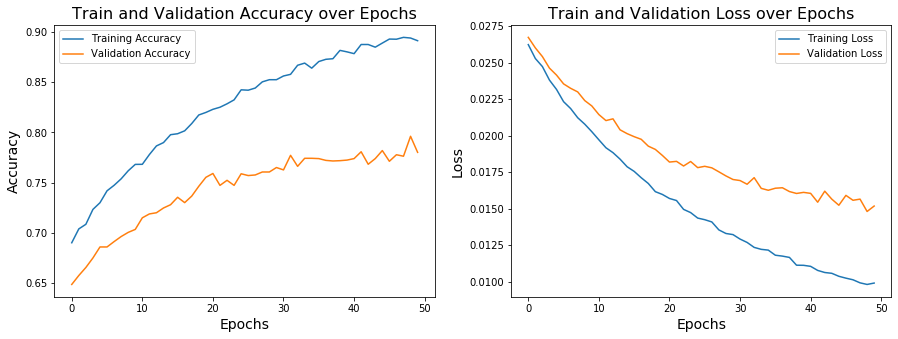

In [5]:
epochs = np.arange(0,50)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs, train_acc, label="Training Accuracy")
ax1.plot(epochs, val_acc, label="Validation Accuracy")
ax1.set_title("Train and Validation Accuracy over Epochs",fontsize=16)
ax1.set_xlabel("Epochs",fontsize=14)
ax1.set_ylabel("Accuracy",fontsize=14)
ax1.legend()

ax2.plot(epochs, train_loss, label="Training Loss")
ax2.plot(epochs, val_loss, label="Validation Loss")
ax2.set_title("Train and Validation Loss over Epochs",fontsize=16)
ax2.set_xlabel("Epochs",fontsize=14)
ax2.set_ylabel("Loss",fontsize=14)
ax2.legend()

plt.savefig("acc_loss_plot.png", dpi=1200)